In [1]:
import kagglehub
import shutil
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from PIL import Image
from torchvision.transforms import v2
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")
target_dir = "/brain_scans"

!mkdir -p {target_dir}
shutil.move(path, target_dir)

print(f"Dataset moved to: {target_dir}")


100%|██████████| 361M/361M [00:03<00:00, 104MB/s]

Extracting files...


Dataset moved to: /brain_scans


In [3]:
directories = ["/brain_scans/1/Dataset/Brain Tumor CT scan Images/Healthy",
               "/brain_scans/1/Dataset/Brain Tumor CT scan Images/Tumor",
               "/brain_scans/1/Dataset/Brain Tumor MRI images/Healthy",
               "/brain_scans/1/Dataset/Brain Tumor MRI images/Tumor"
               ]

image_files = [[] for _ in range(len(directories))]

for i, dir in enumerate(directories):
  image_files[i] = [f for f in os.listdir(dir) if f.endswith('.jpg')]

In [4]:
def see_least(image_files) -> int: #desc shall be added
  import numpy as np
  from typing import List
  return np.min([np.shape(row)[0] for row in image_files])

In [5]:
see_least(image_files)

1716

In [6]:
image_files[1][1]

'ct_tumor (1502).jpg'

The conclusions to be derived from this, shall be as follow, the network should be of mediocre depth, the data should be augmented, and in the second step I presume that making double or triple Conv2d, might yield proper results due to the  

In [7]:
path = "/brain_scans/1/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (1196).jpg"
img = Image.open(path)
width, height = img.size
height

640

In [8]:
group_sizes = [np.shape(group)[0] for group in image_files] #They should be of equal sizes i.e. for now the model will(in terms of logical inference) be biased towards saying cancer
group_sizes

[1716, 2157, 1997, 2984]

In [9]:
widths, heights = [[0 for x in range(group_sizes[y])] for y in range(4)], [[0 for x in range(group_sizes[y])] for y in range(4)]
for i, group in enumerate(image_files):
  for j, file in enumerate(group):
    path = directories[i] + f"/{file}"
    img = Image.open(path)
    width, height = img.size
    widths[i][j] = width
    heights[i][j] = height




In [10]:
np.min([np.min(row) for row in widths])

100

In [11]:
np.max([np.max(row) for row in widths]) # This easy test proofs the disproportions, I shall do smth about this.

1375

In [12]:
def show_images():
  cancer_scans_in_divisions = ["Healthy, CT scan images",
                              "Sick, CT scan images",
                              "Healthy MRI images",
                              "Sick MRI images"]
  print("Brain scans pre-classified by tumor occurence \n\n\n")

  for i, group in enumerate(image_files):

    images = [[None for _ in range(2)] for _ in range(2)]

    rand_img_indices = []

    for j in range(2):
      for k in range(2):
        rand_img_index = np.random.randint(low=0, high=len(group))
        if not rand_img_indices:
          rand_img_indices.append(np.random.randint(low=0, high=len(group)))
        else:
          if rand_img_index in rand_img_indices:
            while rand_img_index in rand_img_indices:
              rand_img_indices.append(np.random.randint(low=0, high=len(group)))
          else:
            rand_img_indices.append(np.random.randint(low=0, high=len(group)))
        imgpath = os.path.join(directories[i], group[rand_img_index])
        print(Image.open(imgpath).size[0])
        img = mpimg.imread(imgpath)
        images[j][k] = img

    random_img_indices_2d = [[rand_img_indices[x] for x in range(y*2, (y+1)*2)] for y in range(2)]

    fig, axes = plt.subplots(figsize=(9, 6),
                              nrows=2,
                              ncols=2
                            )


    for k, row in enumerate(axes):
      for l, element in enumerate(axes[k]):
        element.imshow(images[k][l], cmap="gray")
        element.set_title(f"Scan number {random_img_indices_2d[k][l]}., file size = {Image.open(imgpath).size[0]} x {Image.open(imgpath).size[1]}")
        element.axis('off')
    plt.suptitle(f"{cancer_scans_in_divisions[i]}")
    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("\n\n")


Brain scans pre-classified by tumor occurence 



640
640
640
640


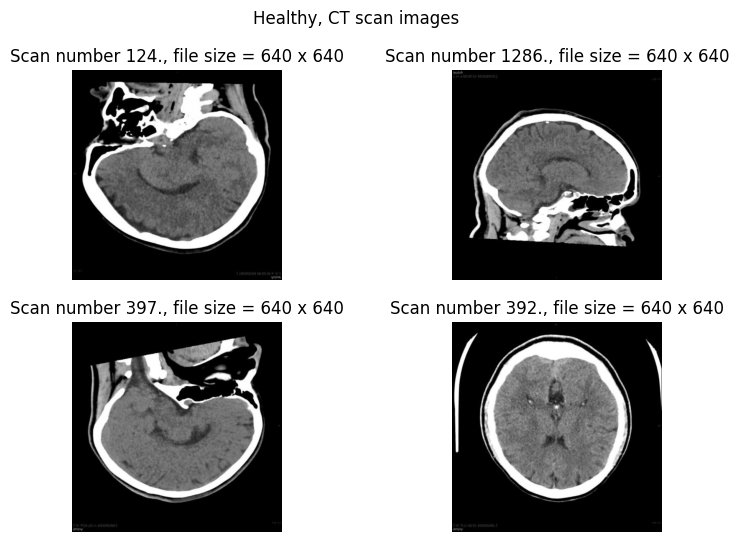




640
640
640
640


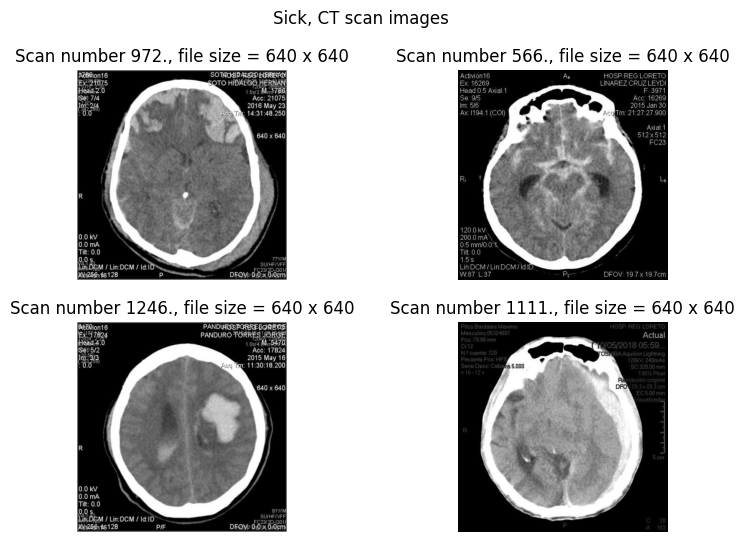




275
256
236
200


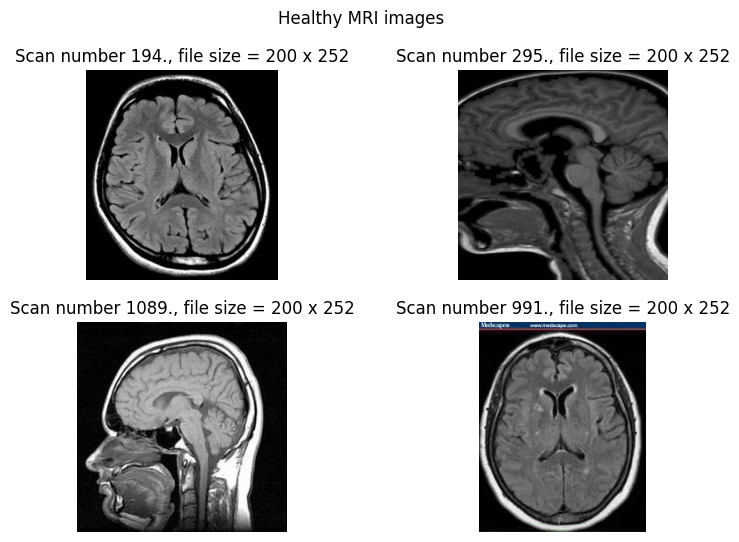




512
512
512
398


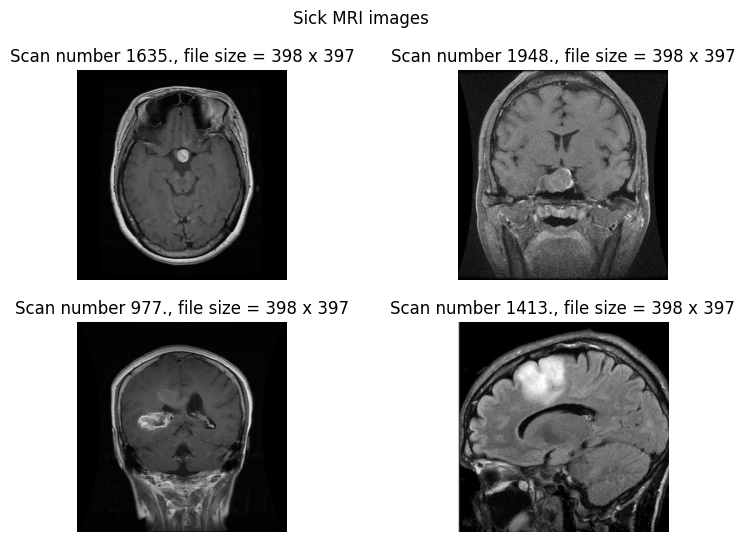

In [13]:
show_images()

In [14]:
"""
WIthin checking the current structure of the images with the dataset, I shall split the data into categories min-256px, 256-513, 513-max, within the
visualization, and the focus shall be redirected to the cancer positive images, due to their more specific (intricate) relationships between pixels (I assume)
"""

'\nWIthin checking the current structure of the images with the dataset, I shall split the data into categories min-256px, 256-513, 513-max, within the\nvisualization, and the focus shall be redirected to the cancer positive images, due to their more specific (intricate) relationships between pixels (I assume)\n'

In [15]:
cancer_scans_in_divisions = ["Healthy, CT scan images",
                             "Sick, CT scan images",
                             "Healthy MRI images",
                             "Sick MRI images"]

def images_by_their_size(min_size: int, max_size: int, resizer=False, scaler=224) -> None:
    print("Brain scans pre-classified by tumor occurrence\n\n\n")

    if resizer:
        resizer = v2.Resize((scaler, scaler))  # Resize to (scaler, scaler)

    for i, group in enumerate(image_files):
        images = [[None for _ in range(2)] for _ in range(2)]
        rand_img_indices = set()

        limit = 100
        for j in range(2):
            for k in range(2):
                attempts = 0
                while attempts < limit:
                    rand_img_index = np.random.randint(low=0, high=len(group))
                    if rand_img_index not in rand_img_indices:
                        imgpath = os.path.join(directories[i], group[rand_img_index])
                        img_size = Image.open(imgpath).size
                        if min_size <= img_size[0] < max_size and min_size <= img_size[1] < max_size:
                            rand_img_indices.add(rand_img_index)
                            img = mpimg.imread(imgpath)
                            if resizer:
                                img = np.array(resizer(Image.fromarray(img)))
                            images[j][k] = img
                            break
                    attempts += 1
                else:
                    print(f"Warning: Unable to find a valid image for position ({j}, {k})")
                    images[j][k] = None

        if len(rand_img_indices) < 4:
            print("Insufficient images were found to fill all slots.")
            continue

        fig, axes = plt.subplots(figsize=(9, 6), nrows=2, ncols=2)
        for k, row in enumerate(axes):
            for l, ax in enumerate(row):
                if images[k][l] is not None:
                    ax.imshow(images[k][l], cmap="gray")
                    ax.set_title(f"Scan number {list(rand_img_indices)[k * 2 + l]}, size: {scaler if resizer else img_size}")
                ax.axis('off')
        plt.suptitle(f"{cancer_scans_in_divisions[i]}")
        plt.show()
        print("\n\n")


Brain scans pre-classified by tumor occurrence





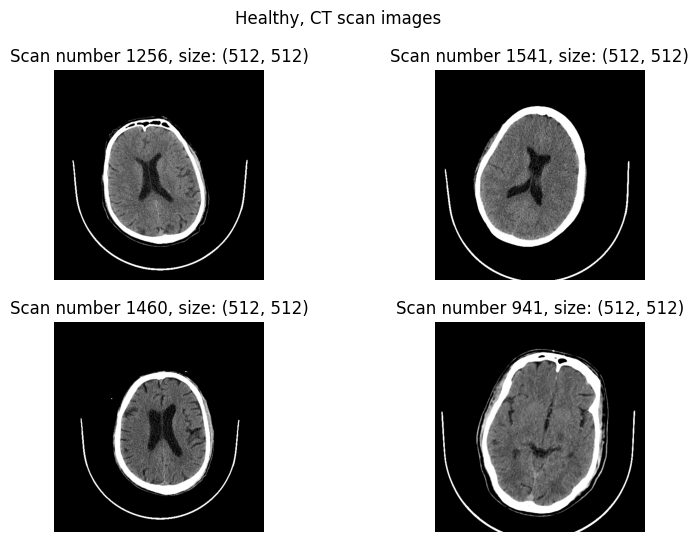




Insufficient images were found to fill all slots.


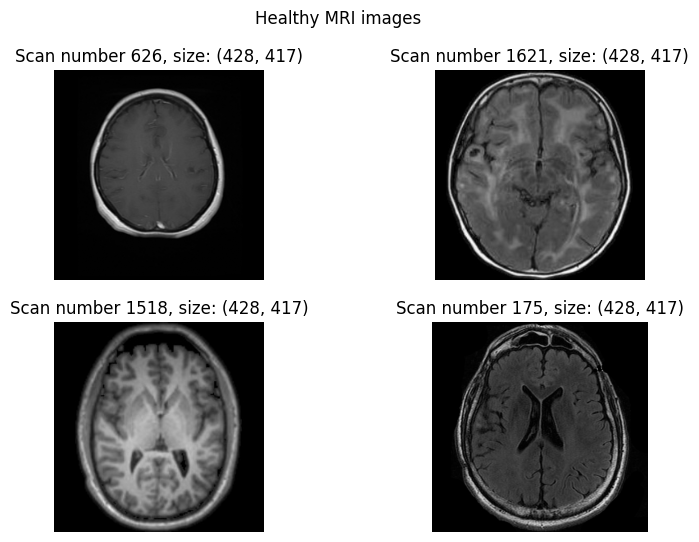

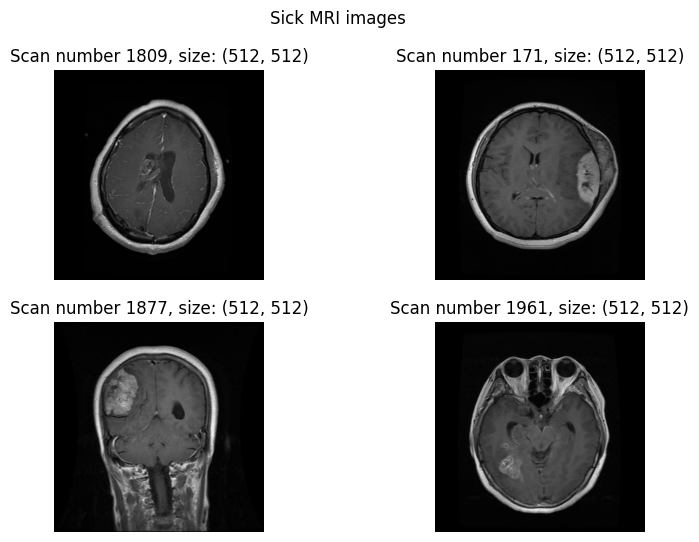

In [16]:
images_by_their_size(256, 513)

In [17]:
"""
It seems that scaling the images
will be appropriate to 256 pixels by 256 pixels, this is 2^8, so for PC it will be perfect in terms of computational prowess, but generally 128x128 would be too
low, and some images could be too blurry, also we can infer this by the resolutions provided, for the dataset, data barely reaches 100's pixels, indicating
that doctors might find it cumbersome to find such images valid (NN should do this better, but we shall set some benchmark to start with firstly)
Thus normally I will try to use some architecture like maybe VGGnet (224x224 is quite similiar to my chosen value, and should preserve properly),
but I intended this notebook for exploratory, thus I won't use transfer learning, and with proper comprehension of the data, I shall create a CNN model, and then
my current idea is to transfer learn this model to another one, i.e. from CT -> MRI and reversively (this should give me a proper variation within the loss
function gradient landscape, the gradients shall be similiar for both of them... thus four models will be created (two auxiliary ones))

P.S. most images are within the square'ish shapes thus x * y (i.e. y = x), and additionally 2^8 = 256.

"""

"\nIt seems that scaling the images\nwill be appropriate to 256 pixels by 256 pixels, this is 2^8, so for PC it will be perfect in terms of computational prowess, but generally 128x128 would be too\nlow, and some images could be too blurry, also we can infer this by the resolutions provided, for the dataset, data barely reaches 100's pixels, indicating\nthat doctors might find it cumbersome to find such images valid (NN should do this better, but we shall set some benchmark to start with firstly)\nThus normally I will try to use some architecture like maybe VGGnet (224x224 is quite similiar to my chosen value, and should preserve properly),\nbut I intended this notebook for exploratory, thus I won't use transfer learning, and with proper comprehension of the data, I shall create a CNN model, and then\nmy current idea is to transfer learn this model to another one, i.e. from CT -> MRI and reversively (this should give me a proper variation within the loss\nfunction gradient landscape, t

For now I shall split the data into sets, but just afore that I will resize them to the desired pixel values, note that this sole action won't provide data leakage within the confounds of reason i.e. input must be stationary i.e. explanatory via it's non-relative size.

In [18]:
# for i, group in enumerate(images_resized):
  # print(len(group))

Brain scans pre-classified by tumor occurrence





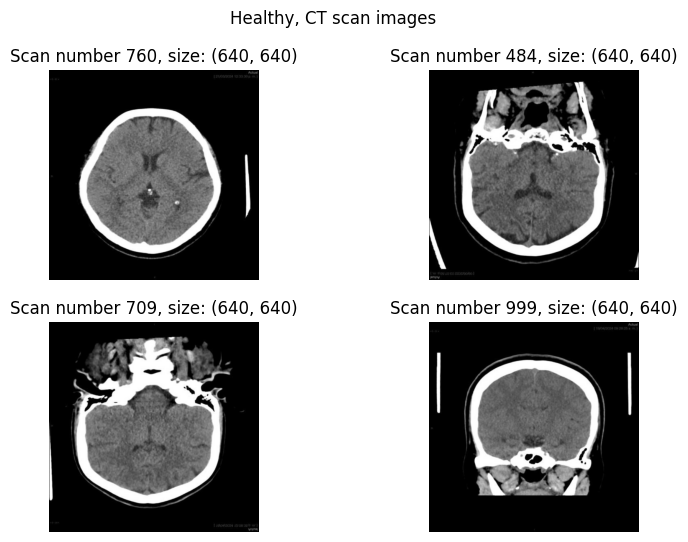

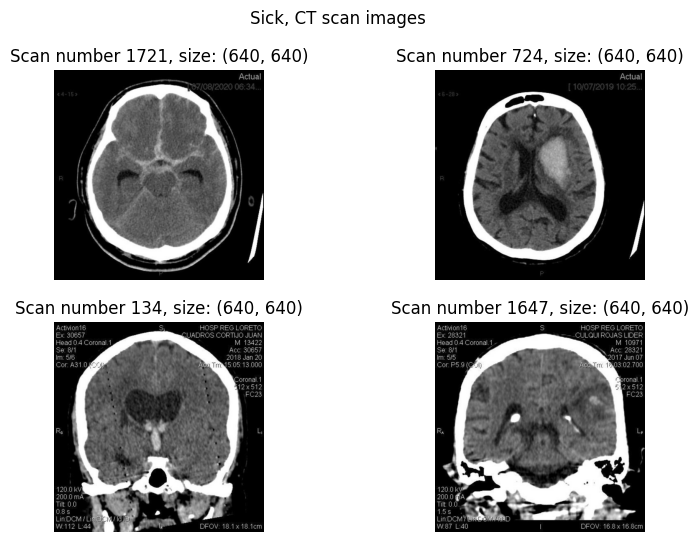

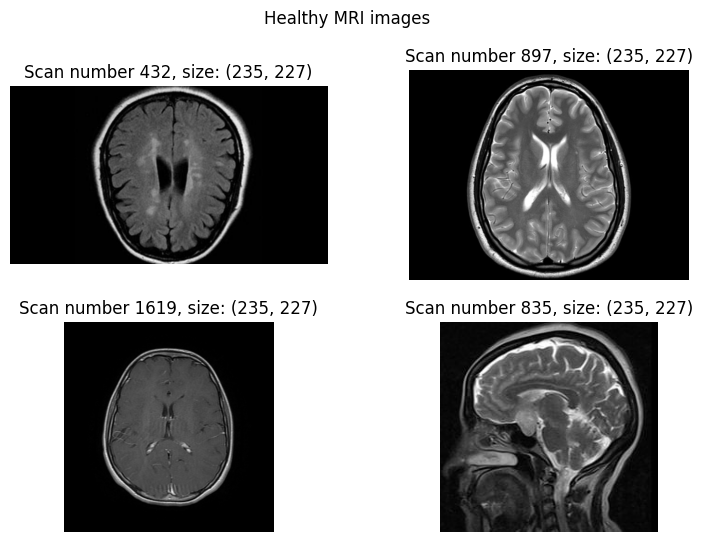

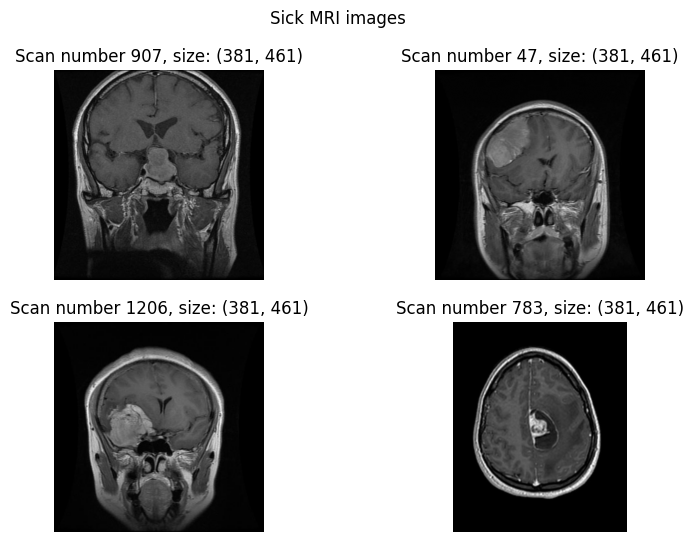

In [19]:
images_by_their_size(2, 2000)

Brain scans pre-classified by tumor occurrence





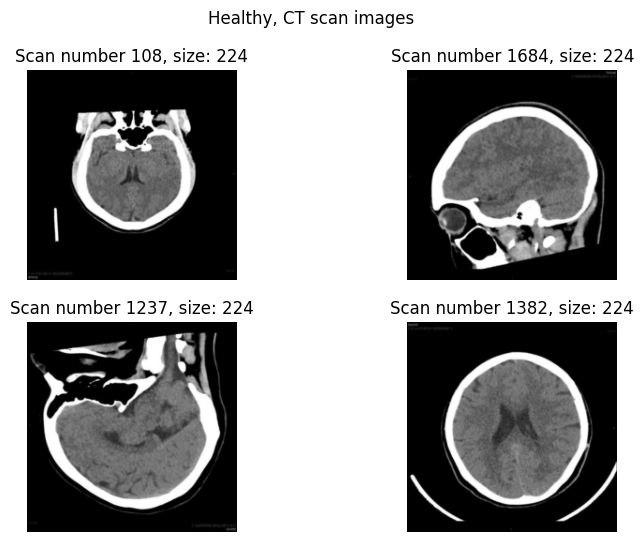

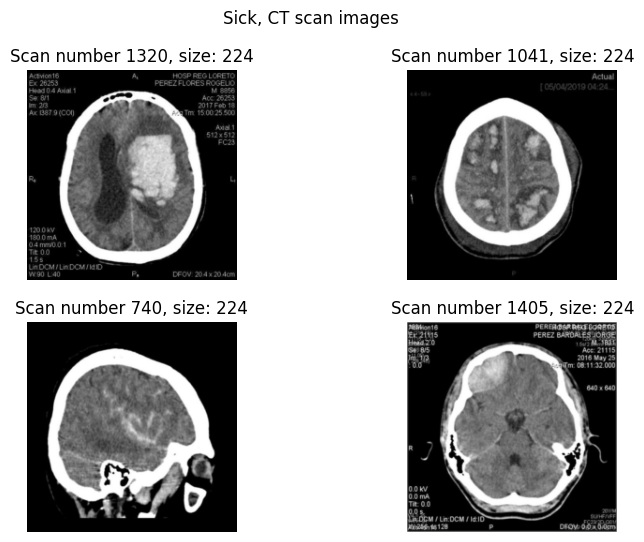

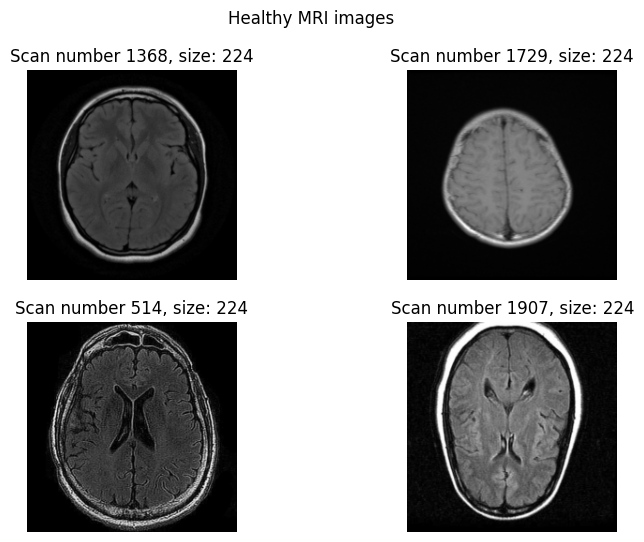

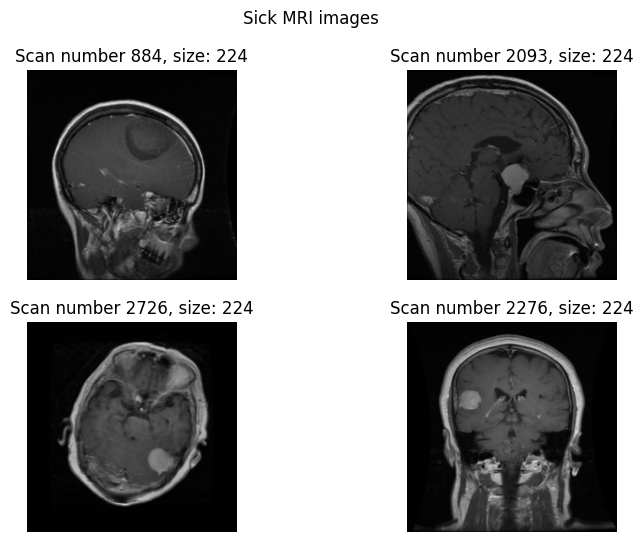

In [20]:
images_by_their_size(2, 2000, resizer = True, scaler = 224)

In [21]:
data_transformation = v2.Compose([
    #v2.RandomRotation(degrees=4), # It is too much, it distorts this image too much
    v2.RandomVerticalFlip(0.8),
    v2.RandomHorizontalFlip(0.8),
    # v2.RandomResizedCrop(x, x), This also shall not be a good idea, for my previous inference yielded, that I should not go below 196^2
    # v2.RandomResizedCrop(size=(170, 170)), I shouldnt use it, for brain tumor in some pictures might be invisible, cause of crop
    #v2.ColorJitter(brightness=0.2, contrast=0.2), # i though that to a little whit it might be good, but it fails...
    v2.Pad(padding = 20), # roughly 10% of the basic image shall be a good level
    #Random invert should make it too hard for model, to see intricacies... (I will not even test it, generally for things like crop i wont even do them)
    #v2.RandomAdjustSharpness(sharpness_factor=2, p=0.65), # Bad idea, images are too distorted...
    v2.Resize((196, 196)), # General resizing will happen on the fly, this is upscaling, to make it harder for model to overfit
    v2.Grayscale(num_output_channels=1),
    v2.ToTensor()
])
#This is the final version of this v2.Compose object
#In my model I will use CV, thus I shall augment the data on the fly

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [22]:
cancer_scans_in_divisions = ["Healthy, CT scan images",
                             "Sick, CT scan images",
                             "Healthy MRI images",
                             "Sick MRI images"]

def images_from_numpy_preprocessed(augmenter = v2.Compose([v2.ToTensor()])) -> None:
    print("Brain scans pre-classified by tumor occurrence, with given preprocessing\n\n\n")

    for i, group in enumerate(image_files):
        images = [[None for _ in range(2)] for _ in range(2)]
        rand_img_indices = set()

        limit = 100
        for j in range(2):
            rand_img_index = np.random.randint(low=0, high=len(group))
            while rand_img_index in rand_img_indices:
                rand_img_index = np.random.randint(low=0, high=len(group))
            imgpath = os.path.join(directories[i], group[rand_img_index])
            img = Image.open(imgpath)
            img = img.convert('L')
            img = torch.from_numpy(np.array(img)).float()
            img = img.unsqueeze(0)
            images[j][0] = img
            images[j][1] = augmenter(img)

        fig, axes = plt.subplots(figsize=(9, 6), nrows=2, ncols=2)
        for k, row in enumerate(axes):
            for l, ax in enumerate(row):
                ax.imshow(images[k][l].squeeze().numpy(), cmap="gray")
                if l == 0:
                  ax.set_title(f"Original brain scan")
                else:
                  ax.set_title(f"Augmented brain scan")
                ax.axis('off')
        plt.suptitle(f"{cancer_scans_in_divisions[i]}")
        plt.show()
        print("\n\n")


Brain scans pre-classified by tumor occurrence, with given preprocessing





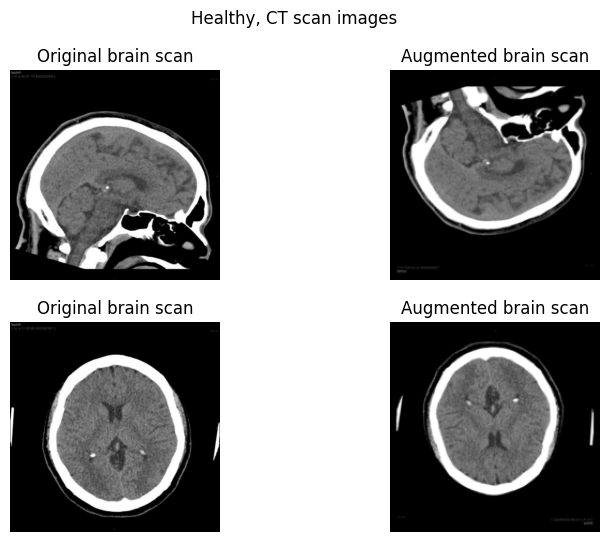

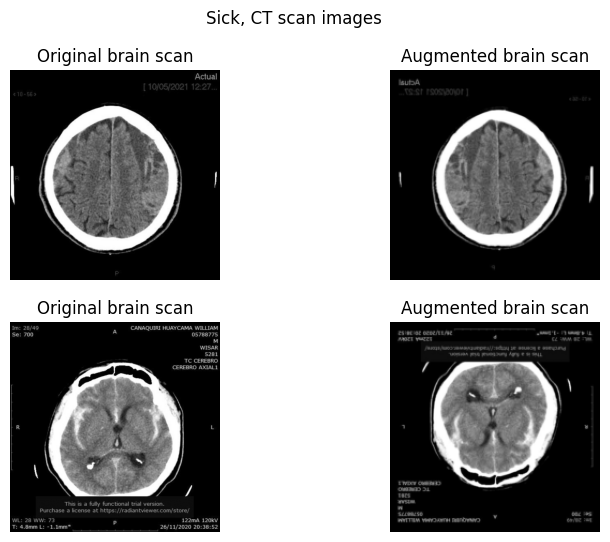

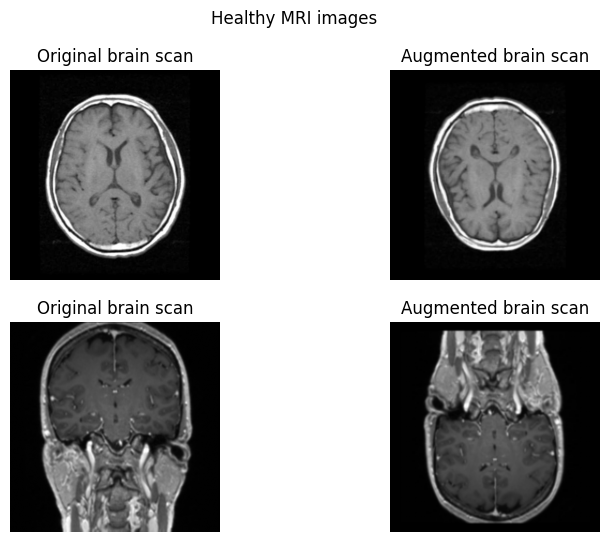

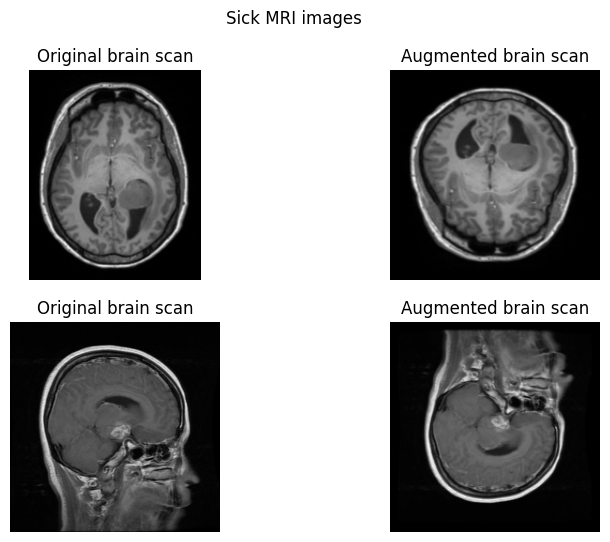

In [23]:
images_from_numpy_preprocessed(data_transformation)
# images_from_numpy_preprocessed()

In [24]:
"""
directories = ["/brain_scans/1/Dataset/Brain Tumor CT scan Images/Healthy",
               "/brain_scans/1/Dataset/Brain Tumor CT scan Images/Tumor",
               "/brain_scans/1/Dataset/Brain Tumor MRI images/Healthy",
               "/brain_scans/1/Dataset/Brain Tumor MRI images/Tumor"
               ]
"""


images_resized = [[] for _ in range(len(directories))]

resizer = v2.Resize((196, 196))

for i, group in enumerate(image_files):
  for j, path in enumerate(group):
    img_path = os.path.join(directories[i], path)
    try:
      img = Image.open(img_path)
      img = img.convert('L')
      img = resizer(img)
      img.save(img_path)
    except Exception as e:
      print(f"The error: {e} occured in image: {img_path}")
    finally:
      img = torch.from_numpy(np.array(img)).float()
      img = img.unsqueeze(0)
      images_resized[i].append(resizer(img))

"""

images_resized[0] -> CT scan Healthy
images_resized[1] -> CT scan Sick
images_resized[2] -> MRI scan Healthy
images_resized[3] -> MRI scan Sick

"""

'\n\nimages_resized[0] -> CT scan Healthy\nimages_resized[1] -> CT scan Sick\nimages_resized[2] -> MRI scan Healthy\nimages_resized[3] -> MRI scan Sick\n\n'

MRI scan is more accurate for brain scans, but they seem to capture similiar patterns, generaslly I will try two models first is to combine two feasible scans, then the idea (lest the first one will not be accurate) would be to use transfere learning from MRI to CT and vice versa. (I made on meself from the starting point to not use any pre-trained models, on this topic).

In [25]:
for i, group in enumerate(images_resized):
  print(len(group))
# I cannot make it biased towards Sick that much, even though that recall is much more important here, for first model I shall
# use the same sizes of the MRI and CT relatively to themselves i.e. n/k = j/l

1716
2157
1997
2984


In [26]:
healthy = 0
sick = 0
for i, group in enumerate(images_resized):
    if i % 2 == 0: healthy += len(images_resized[i])
    else: sick += len(images_resized[i])
print(healthy, sick)

3713 5141


I need 1428 augmented images in pattern x/1716 = y/1997. Solve: x + y = 1428,
x/1716 = y/1997   --->  x = 660, and y = 768, I will do CV, thus I shall augment them on the fly.

Additionally I shall take 10% of the data in CV for validation and 5% for the ultimate test set. 5141...   257 (*2 i.e. sick + healthy) for testset
and 514 (*2 i.e. sick + healthy) for validation set
First of all I will subtract the testset, and then I shall

In [27]:
# print(images_resized[0][0].shape)
check = images_resized[0][0].shape
for i, group in enumerate(images_resized):
  for j, image in enumerate(group):
    if image.shape != check:
      print(f"Image with index {i}, {j} doesnt follow resized order")
      break
  else:
    continue
  break

In [28]:
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BrainScanDataset(Dataset):
  def __init__(self, images_labeled, transform=None):
    self.images_labeled = list(zip(*images_labeled))
    self.transform = transform

  def __len__(self):
    return len(self.images_labeled)

  def __getitem__(self, idx):
    img_path, label = self.images_labeled[idx]
    img = Image.open(img_path)

    if self.transform:
      img = self.transform(img)

    label = torch.tensor(label, dtype=torch.long)

    return img.to(device), label.to(device)


In [29]:
from sklearn.model_selection import train_test_split

all_images = []
for i, dir in enumerate(directories):
  for j, file in enumerate(os.listdir(dir)):
    all_images.append((os.path.join(dir, file), i % 2)) # Healthy -> 0, Tumor -> 1

paths, labels = zip(*all_images)

paths, labels = list(paths), list(labels)

X_train, X_temp, y_train, y_temp = train_test_split(paths, labels, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

train_dataset = BrainScanDataset((X_train, y_train), transform=data_transformation)
val_dataset = BrainScanDataset((X_val, y_val), transform=None)
test_dataset = BrainScanDataset((X_test, y_test), transform=None)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

I must concatanate proper

In [30]:
# Model 0 will serve for basic ideas within Optuna optimization.
#Images are all sized 196x196

class Model_0(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=48, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1)
    self.pool1 = nn.AvgPool2d(2, 2)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.pool3 = nn.AvgPool2d(2, 2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(55296, 256) # 24^2 * 96
    self.fc2 = nn.Linear(256, 1)
  def forward(self, x):
    x = self.pool1(self.conv1(x))
    x = self.pool2(self.conv2(x))
    x = self.pool3(self.conv3(x))
    x = self.flatten(x)
    x = self.fc2(F.relu(self.fc1(x)))
    return x

# model = Model_0()
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# lossfun = torch.nn.BCEWithLogitsLoss()

In [31]:
from re import A
import os
import random
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader, ConcatDataset

healthy_dirs = [
    "/brain_scans/1/Dataset/Brain Tumor CT scan Images/Healthy",
    "/brain_scans/1/Dataset/Brain Tumor MRI images/Healthy"
]

base_transform = v2.Compose([
  v2.Grayscale(num_output_channels=1),
  v2.Resize((196, 196)),
  v2.ToTensor()
])

healthy_images = []
for directory in healthy_dirs:
  image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg')]
  healthy_images.extend(image_files)

selected_healthy_images = random.sample(healthy_images, 1428)
selected_healthy_labels = [0] * len(selected_healthy_images)

all_images = list(zip(paths, labels))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_images)):
  print(f"Fold {fold+1}/{kf.get_n_splits()}")

  model = Model_0().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  lossfun = torch.nn.BCEWithLogitsLoss()

  train_data = [all_images[i] for i in train_idx]
  val_data = [all_images[i] for i in val_idx]

  X_train, y_train = zip(*train_data)
  X_val, y_val = zip(*val_data)

  X_train, y_train = list(X_train), list(y_train)
  X_val, y_val = list(X_val), list(y_val)

  train_dataset_original = BrainScanDataset((X_train, y_train), transform=base_transform)
  val_dataset = BrainScanDataset((X_val, y_val), transform=base_transform)

  augmented_dataset = BrainScanDataset((selected_healthy_images, selected_healthy_labels), transform=data_transformation)

  extended_train_dataset = ConcatDataset([train_dataset_original, augmented_dataset])

  train_loader = DataLoader(extended_train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

  num_epochs = 10

  i = 0
  avg_val_loss = 0

  for epoch in range(num_epochs):
    i+=1
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    total_loss_train = 0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images).squeeze()
      loss = lossfun(outputs, labels.float())
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      predicted = (torch.sigmoid(outputs) > 0.5).long()
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      total_loss_train += loss.item()

    avg_train_accuracy = total_loss_train / total
    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Average Loss: {total_loss/total:.4f} Train Acc: {train_accuracy:.2f}%")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        predicted = (torch.sigmoid(outputs) > 0.5).long()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      val_accuracy = 100* correct / total
      avg_val_loss += val_accuracy / 1000
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

  """
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in val_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images).squeeze()
          predicted = (torch.sigmoid(outputs) > 0.5).long()
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  val_accuracy = 100 * correct / total
  fold_accuracies.append(val_accuracy)
  """
  print(f"Fold {fold+1} Average Validation accuracy was: {avg_val_loss:.4f}")

print(f"\nFinal Cross-Validation Accuracy: {sum(fold_accuracies) / len(fold_accuracies):.4f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Fold 1/5
Epoch 1/10
Epoch [1/10], Loss: 133.4694, Average Loss: 0.0146 Train Acc: 78.20%
Epoch 2/10
Epoch [2/10], Loss: 94.2997, Average Loss: 0.0103 Train Acc: 86.26%
Epoch 3/10
Epoch [3/10], Loss: 66.7092, Average Loss: 0.0073 Train Acc: 90.98%
Epoch 4/10
Epoch [4/10], Loss: 53.0882, Average Loss: 0.0058 Train Acc: 92.67%
Epoch 5/10
Epoch [5/10], Loss: 41.7011, Average Loss: 0.0046 Train Acc: 94.73%
Epoch 6/10
Epoch [6/10], Loss: 27.8505, Average Loss: 0.0031 Train Acc: 96.76%
Epoch 7/10
Epoch [7/10], Loss: 22.1470, Average Loss: 0.0024 Train Acc: 97.41%
Epoch 8/10
Epoch [8/10], Loss: 16.9201, Average Loss: 0.0019 Train Acc: 98.09%
Epoch 9/10
Epoch [9/10], Loss: 13.8940, Average Loss: 0.0015 Train Acc: 98.41%
Epoch 10/10
Epoch [10/10], Loss: 9.5335, Average Loss: 0.0010 Train Acc: 98.94%
Fold 1 Validation Accuracy: 94.75%
Fold 2/5
Epoch 1/10
Epoch [1/10], Loss: 140.0693, Average Loss: 0.0154 Train Acc: 76.00%
Epoch 2/10
Epoch [2/10], Loss: 97.1994, Average Loss: 0.0107 Train Acc: 85.

In [32]:
# I shall do this now with Optuna
#Currently average accuracy is within 95%, I shall check for recall additionally